# Calculate Similarity
Given the diverse set of features here (about location, borrower, and the loan itself) let's just start with a really simple similarity metric.  We'll use Jaccard similarity, where each element of a user's set of loans will just get included in a set of loan elements.  Then we'll find a loan that's currently eligible with a large number of overlapping elements.

We could eventually measure similarity across different metrics and weight more important ones more heavily, but to start let's just throw everything in the same set.

The downside of this is that if someone consistently prefers the same country (for example) that's only indirectly accounted for in the small size of the set of elements (because that country would be counted only once, though it occurred many times.)  However, this will work as a proof of concept.

In [1]:
import pandas as pd
import pickle
import pprint
import requests

from country import country_to_continent
from utils import eval_string

path = '/Users/brianna/Dropbox/data_project/loan_project/data/'


## Get loan elements for each eligible loan
Include the following features:
- country
- continent
- sector
- tags
- themes

In [2]:
# Load the dictionary with loan ids and elements for each loan
loan_elements = pickle.load( open( "%sloan_elements.pickle" % path, "rb" ) )

## For a specific user, create a set of all of the elements of his/her previous loans.
Let's look at my loan history for an example.  Because I lived in Uganda and I'm a big fan of woman-owned businesses, I tend to focus on East Africa and women.

In [55]:
def add_element(category, element):
    if element not in category:
        category[element] = 1
    else:
        category[element] += 1
    
    return category
        
def get_user_loan_elements(user):                                                                              
    url = 'http://api.kivaws.org/v1/lenders/{user}/loans.json'.format(user=user)                               
    response = requests.get(url)                                                                               
    lender = eval(response.content.replace('false', 'False').replace('true', 'True'))                          
                                                                                                               
    # To speed up computing time, if a user has a ton of loans only use the 10 most recent.                    
    if len(lender['loans']) > 20:                                                                              
        lender['loans'] = lender['loans'][-20:]                                                                
                                                                                                               
    # Make dictionaries of each of these important categories of the user's loans,
    # where the key is the category (ex. "Woman Owned Biz") and the value is the number
    # of times it's appeared in this user's loans
    countries, continents, sectors, tags, themes = {}, {}, {}, {}, {}                       
                                                                                                               
    for loan in range(len(lender['loans'])):                                                                   
        if 'country' in lender['loans'][loan]['location']:
            country = lender['loans'][loan]['location']['country']
            countries = add_element(countries, country)
            continent = country_to_continent.get(country, 'Unknown')
            continents = add_element(continents, continent)       
                                                                                                               
        if 'sector'in lender['loans'][loan]: 
            sector = lender['loans'][loan]['sector']
            sectors = add_element(sectors, sector)                                                
                                                                                                               
        if 'tags' in lender['loans'][loan]:                                                                    
            loan_tags = [k['name'].strip('#') for k in lender['loans'][loan]['tags']]  
            for t in loan_tags:
                tags = add_element(tags, t)                                                                             
                                                                                                               
        if 'themes' in lender['loans'][loan]:                                                                  
            loan_themes = lender['loans'][loan]['themes'] 
            for th in loan_themes:
                themes = add_element(themes, th)                                                                       
                              
        # Find the gender of the borrowers for each loan.  (For this we actually have to return
        # to the loans API)
#         url = 'http://api.kivaws.org/v1/loans/'
#         for i in range(len(lender['loans'])):
#             # API call an only include 50 loans at a time
#             if i > 49:
#                 break    
#             url += '%s,' % lender['loans'][i]['id']

#         url = '%s.json' % url[:-1]

#         response = requests.get(url)                                                                     
#         user_loans = eval(response.content.replace('false', 'False').replace('true', 'True'))['loans'] 

#         borrower_genders_all_loans = []
#         for i in range(len(user_loans)):
#             borrower_genders_this_loan = [k['gender'] for k in user_loans[i]['borrowers']]
#             borrower_genders_all_loans = borrower_genders_all_loans + borrower_genders_this_loan

#         user_borrowers = {'F': borrower_genders_all_loans.count('F'),
#                           'M': borrower_genders_all_loans.count('M')}

        user_loan_elements = {'user_countries': countries,                                                     
                              'user_continents': continents,                                                   
                              'user_sectors': sectors,                                                         
                              'user_tags': tags,                                                               
                              'user_themes': themes}                                                           
                                                                                                               
    return user_loan_elements   

def get_user_loan_elements_and_counts(user_loan_elements):                                         
    # Combine elements from each category into a single set to calculate similarity         
    user_loan_elements_set = {}
    for category in user_loan_elements: 
        for element in user_loan_elements[category]:
            user_loan_elements_set.update(user_loan_elements[category])
    return user_loan_elements_set

def get_user_loan_elements_categories_only(user_loan_elements):                                         
    # Combine elements from each category into a single set to calculate similarity         
    user_loan_elements_set = set()                                                          
    for category in user_loan_elements:                                                           
        user_loan_elements_set.update(user_loan_elements[category])                               
    return user_loan_elements_set                                                           

In [56]:
user = 'brianna9306'
user = 'monica5588'
user_loan_elements = get_user_loan_elements(user)

In [57]:
user_loan_elements

{'user_continents': {'Africa': 1,
  'Asia': 6,
  'Europe': 10,
  'North_America': 1,
  'South_America': 2},
 'user_countries': {'Armenia': 7,
  'Ecuador': 1,
  'El Salvador': 1,
  'Georgia': 2,
  'Kenya': 1,
  'Kyrgyzstan': 2,
  'Peru': 1,
  'Philippines': 2,
  'Tajikistan': 2,
  'Ukraine': 1},
 'user_sectors': {'Agriculture': 10,
  'Food': 6,
  'Housing': 1,
  'Services': 2,
  'Transportation': 1},
 'user_tags': {'Animals': 1,
  'Biz Durable Asset': 4,
  'Elderly': 1,
  'First Loan': 1,
  'Parent': 3,
  'Repeat Borrower': 1,
  'Schooling': 1,
  'Single Parent': 1,
  'Supporting Family': 2,
  'Sustainable Ag': 1,
  'Technology': 1,
  'Vegan': 1,
  'Widowed': 1,
  'Woman Owned Biz': 2,
  'user_favorite': 4},
 'user_themes': {'Rural Exclusion': 1, 'Start-Up': 1, 'Youth': 1}}

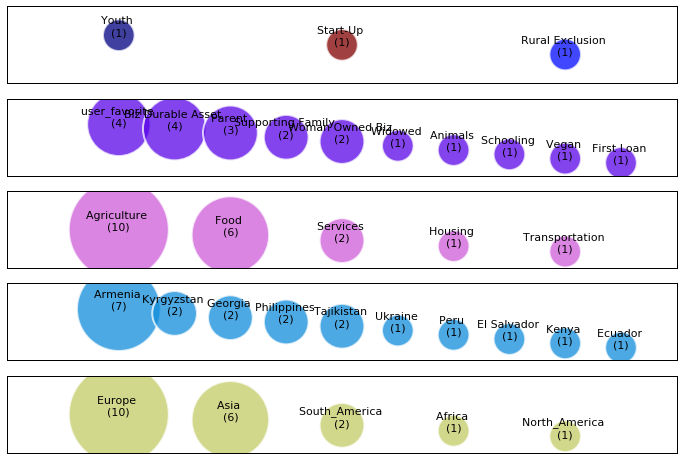

In [179]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 5, 1)
p = 1
for category in ['user_themes', 'user_tags', 'user_sectors', 'user_countries', 'user_continents']:
    plt.subplot(5, 1, p)

    elements = user_loan_elements[category].items()
    elements.sort(key=lambda x: x[1], reverse=True) 
    if len(elements) > 10:
        elements = elements[:10]

    n = len(elements)
    x = range(n)
    y = [(n - i) * .1 for i in x]
    area = []
    for i in x:
        text(x[i], y[i], '%s \n(%s)' % (elements[i]), size=11, horizontalalignment='center')
        area.append(elements[i][1] * 1000)
#     text(x[-1], y[0], category, size=13, horizontalalignment='center')
    sct = scatter(x, y, c=np.random.rand(3, 1), s=area, linewidths=2, edgecolor='w')
    sct.set_alpha(0.75)
    p += 1

    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', right='off', left='off', labelleft='off')
# plt.get_xaxis().set_visible(False)

# axis([0,11,200,1280])
#xlabel('Category')
#ylabel('Number of Instances')
plt.show()


In [181]:
from bokeh.charts import Bar, output_file, show
from bokeh.sampledata.autompg import autompg as df

p = Bar(df, label='origin', values='mpg', agg='mean', stack='cyl',
        title="Avg MPG by ORIGIN, stacked by CYL", legend='top_right')

# output_file("bar.html")

show(p)

In [182]:
from bokeh.charts import Donut, show, output_file
from bokeh.charts.utils import df_from_json
from bokeh.sampledata.olympics2014 import data

import pandas as pd

# utilize utility to make it easy to get json/dict data converted to a dataframe
df = df_from_json(data)

# filter by countries with at least one medal and sort by total medals
df = df[df['total'] > 8]
df = df.sort_values(by="total", ascending=False)
df = pd.melt(df, id_vars=['abbr'],
             value_vars=['bronze', 'silver', 'gold'],
             value_name='medal_count', var_name='medal')

# original example
d = Donut(df, label=['abbr', 'medal'], values='medal_count',
          text_font_size='8pt', hover_text='medal_count')

output_file("donut.html")

show(d)


In [211]:
# from highcharts import Highchart
# base = Highchart.getOptions().colors[0]
import random

random.choice(colors)



'#058DC7'

In [220]:
from highcharts import Highchart
from colors import reds, blues, greens, oranges

category = 'user_sectors'
data = []
for el in user_loan_elements[category]:
    data.append({'name': el, 
                 'y': user_loan_elements[category][el],
                 'color': random.choice(oranges)})

# Define the options of the chart
options = { # construct option dict
  'chart' :{ 'renderTo' : 'container', 'zoomType': 'xy'},
  'title' : {'text' : 'Countries'},
  'tooltip': {
            'useHTML': True,
            'pointFormat': '{point.y} loans ({point.percentage:.1f} %)',
            'followPointer': True
        },
    
} 


# Plot the chart
H = Highchart(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(data, 'pie', ' ',
                dataLabels={
                    'enabled': True,
                    'format': '{point.name}',
                },
              )
# H.save_file('electoral_college_race_age')
H

In [ ]:
print(get_user_loan_elements_only(user_loan_elements))
print('\n')
print(get_user_loan_elements_and_counts(user_loan_elements))

# Similarity Measures

### Jaccard Distance
The simplest way to compute similarity, the number of shared elements divided by the total number of elements.
   - <b>Strengths</b>: Simple to understand, the fit is imperfect but it injects an element of randomness that might be beneficial
   - <b>Weaknesses</b>: Doesn't take into account the nature of the category (ex. treats country the same as sector) or the number of times each category is is associated with the loans (ex. If I take loans 30 loans from Senegal and one from Cambodia, it counts Senegal and Cambodia equally)

In [ ]:
def jaccard_distance(x, user_loan_elements):                                          
    user_loan_elements_set = get_user_loan_elements_categories_only(user_loan_elements)           
    intersection = len(set.intersection(x, user_loan_elements_set))                   
    union = len(set.union(x, user_loan_elements_set))                                 
    if union > 0:                                                                     
        return intersection/float(union)                                              
    else:                                                                             
        return 0      

### Dot Product Similarity
Compute similarity taking into account the number of instances of each element (ie. if someone gives 10 "Agriculture" sector loans and 2 "Clothing" sector loans, their similarity scores will be more heavily weighted toward "Agriculture".)

   - <b>Strengths</b>: If a user has a strong preference in one category, that category will carry more weight, resulting in more loans that are similar in that category
   - <b>Weaknesses</b>: Less intuitive measure, tailored specifically to the eccentricities of the Kiva loan dataset

In [ ]:
def get_max_instance(user_loan_elements, category):
    # Get the maximm number of instances of a particular category (country, continent, sector)
    instances = {v: k for k,v in user_loan_elements[category].iteritems()}
    return max(instances)

def get_sum_of_instances(user_loan_elements, category):
    # Get the maximm number of instances of a particular category (country, continent, sector)
    total_instances = 0
    for k in user_loan_elements[category]:
        total_instances += user_loan_elements[category][k]
    return total_instances

def max_dp_similarity(user_loan_elements):
    # The maximum "similarity score" would be:
    #    - a match with the most common country, continent, and sector
    #    - all tags and themes shared
    dp_max = 0
    for category in ['user_countries', 'user_continents', 'user_sectors']:
        dp_max += get_max_instance(user_loan_elements, category)
    for category in ['user_tags', 'user_themes']:
        dp_max += get_sum_of_instances(user_loan_elements, category)
    return dp_max
    
def dp_similarity(candidate_loan_elements, user_loan_elements):
    user_loan_elements_set = get_user_loan_elements_and_counts(user_loan_elements)
    candidate_loan_elements = list(candidate_loan_elements)
    
    dot_product = sum([user_loan_elements_set.get(k, 0) for k in candidate_loan_elements])
    
    # Normalize by the maximum dot product of the most ideal loan (which is not the same as sharing
    # every element since a loan can in theory share all tags and themes but can only have one 
    # country, continent, and sector
    return dot_product * 1.0 / max_dp_similarity(user_loan_elements)

# Find most similar loans

In [ ]:
# Find which of the currently active loans has the highest overlap with the user_loan_elements
#similarity_scores = {k: jaccard_distance(v['elements'], user_loan_elements) for k, v in loan_elements.iteritems()}
similarity_scores = {k: dp_similarity(v['elements'], user_loan_elements) for k, v in loan_elements.iteritems()}

# Turn the dict into a list of tuples sorted by similarity score
sorted_similarity_scores = sorted(similarity_scores.items(), key=lambda tup: tup[1], reverse=True)

In [ ]:
print('***TOP FIVE SIMILAR LOANS for %s***' % user)
for sim in sorted_similarity_scores[:5]:
    loan_id, similarity_score = sim[0], sim[1]
    print('\nLoan: %s, similarity: %s' % (loan_id, similarity_score))
    print(loan_elements[loan_id]['elements'])


print('\n\n***TOP FIVE WORST LOANS for %s***' % user)
sorted_similarity_scores.reverse()
for sim in sorted_similarity_scores[:5]:
    loan_id, similarity_score = sim[0], sim[1]
    print('\nLoan: %s, similarity: %s' % (loan_id, similarity_score))
    print(loan_elements[loan_id]['elements'])

All of top five "similar" loans are eco-friendly and/or women-owned businesses in Uganda, nice!  And conversely, my five least good fits are in place where I've never given a loan.

In [ ]:
# Let's try someone with different preferences to see how it fits.
user = 'rafael7312'
user_loan_elements = get_user_loan_elements(user)
user_loan_elements

In [ ]:
# Find which of the currently active loans has the highest overlap with the user_loan_elements
#similarity_scores = {k: jaccard_distance(v['elements'], user_loan_elements) for k, v in loan_elements.iteritems()}
similarity_scores = {k: dp_similarity(v['elements'], user_loan_elements) for k, v in loan_elements.iteritems()}

# Turn the dict into a list of tuples sorted by similarity score
sorted_similarity_scores = sorted(similarity_scores.items(), key=lambda tup: tup[1], reverse=True)

print('***TOP FIVE SIMILAR LOANS for %s***' % user)
for sim in sorted_similarity_scores[:5]:
    loan_id, similarity_score = sim[0], sim[1]
    print('\nLoan: %s, similarity: %s' % (loan_id, similarity_score))
    print(loan_elements[loan_id]['elements'])


print('\n\n***TOP FIVE WORST LOANS for %s***' % user)
sorted_similarity_scores.reverse()
for sim in sorted_similarity_scores[:5]:
    loan_id, similarity_score = sim[0], sim[1]
    print('\nLoan: %s, similarity: %s' % (loan_id, similarity_score))
    print(loan_elements[loan_id]['elements'])

Nice, a lot of "Innovative Loans" and "Woman Owned Businesses" in South America.  It would take A/B tests to validate whether these loans would actually be more persuasive to people and result in more loans given, but at face value it's definitely promising.

# Plot Distribution of loan elements for a user

In [8]:
url = 'http://api.kivaws.org/v1/lenders/{user}/loans.json'.format(user=user)
response = requests.get(url)                                                                               
lender = eval(response.content.replace('false', 'False').replace('true', 'True'))                          

In [42]:
user_borrowers

{'F': 62, 'M': 24}